
- Costruire un dataset di grafi di spin glass di piccola taglia (# basso di nodi) e studiare come l'apprendimento dell'energia da parte della GNN cambia al variare della connettività del grafo. Ad esempio fissando a 10 il numero di nodi, il numero di edges può essere cambiato da 9 (open spin glass chain) a 45 (fully connected spin glass) , magari provando 9, 15, 25, 45. Si costruiscono 4 dataset e si allena la stessa GNN separatamente su questi dataset in modo supervised per fare poi il confronto. (Livello medio)

- Costruire un dataset di grafi di spin glass a taglia e connettività fissati (# nodi non troppo alto). Studiare la comparazione tra l'apprendimento della magnetizzazione o dell'energia tra un MLP e una GNN.  Ovviamente in questo caso va ricavata la matrice di adiacenza e la matrice delle features a partire dai grafi per poter allenare l'MLP. (Livello medio)


In [38]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def initialize_graph(L, periodic=True, n_dimensions=2):
    """
    Initialize a graph with L nodes
    """
    G = nx.Graph()
    for i in range(L):
        G.add_node(i, spin = np.random.choice([-1, 1]))
    
    for i in range(L):
        if periodic:
            for j in range(i+1, i+n_dimensions+1):
                G.add_edge(i, j % L, weight = np.random.rand()*2 -1 )
        else:
            for j in range(i+1, i+n_dimensions+1):
                if j < L:
                    G.add_edge(i, j, weight =1.0)
    return G
     

def plot_graph(G, pos=None):
    """
    Plot the graph with nodes colored according to their spin.
    """
    if pos is None:
        pos = nx.circular_layout(G)
    colors = ['blue' if G.nodes[i]["spin"] == 1 else 'red' for i in range(len(G.nodes) )]
    nx.draw(G, pos = pos, node_color=colors, with_labels=True)
    plt.show()
    

def calculate_energy(G, h=0 ):
    """
    Calculate the energy of the graph
    """
    E = 0
    E_h = 0
    for i, j in G.edges:
        E += G[i][j]["weight"] * G.nodes[i]["spin"] * G.nodes[j]["spin"]

    if h != 0:  # exclude the case of h = 0 to avoid floating point errors
        E_h = h * np.sum([G.nodes[i]["spin"] for i in G.nodes]) 


    return -E/2 - E_h  # divide by 2 to avoid double counting

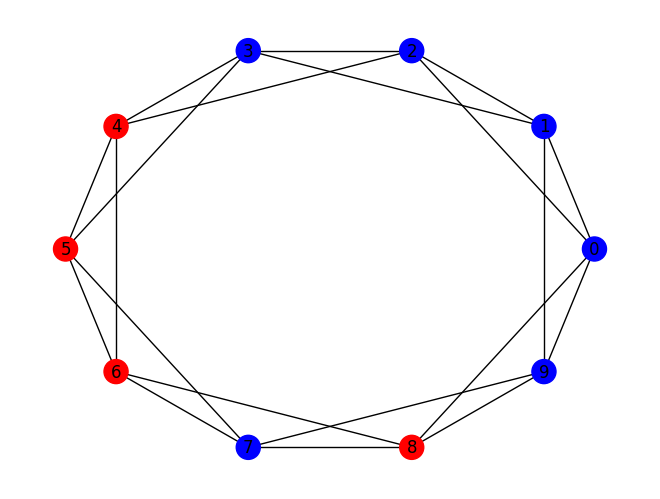

energy for this configuration:  -0.8660204559513519


In [21]:
G = initialize_graph(10, periodic=True, n_dimensions=2)
plot_graph(G)
h = 0
print("energy for this configuration: " , calculate_energy(G, h))

In [35]:
#extract the adjacency matrix
A = nx.adjacency_matrix(G).todense()
print(A)
print()
#extract the node features
X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)
print(X)
print()

M = np.concatenate([X, A], axis=1)

print(M)


[[ 0.         -0.13364414  0.34695163  0.          0.          0.
   0.          0.         -0.52497369  0.11717186]
 [-0.13364414  0.          0.58606721  0.73773518  0.          0.
   0.          0.          0.         -0.86919217]
 [ 0.34695163  0.58606721  0.          0.71067319 -0.44870828  0.
   0.          0.          0.          0.        ]
 [ 0.          0.73773518  0.71067319  0.         -0.80054045  0.2020703
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.44870828 -0.80054045  0.          0.50181172
  -0.54774915  0.          0.          0.        ]
 [ 0.          0.          0.          0.2020703   0.50181172  0.
  -0.15786854 -0.59156069  0.          0.        ]
 [ 0.          0.          0.          0.         -0.54774915 -0.15786854
   0.         -0.02926557  0.12125117  0.        ]
 [ 0.          0.          0.          0.          0.         -0.59156069
  -0.02926557  0.          0.55927523 -0.46846291]
 [-0.52497369  0.          0.    

In [49]:
# create a dataset with the energy as label

dataset = []
MLP_dataset = []

n_nodes = 10
h = 0
periodic = True
n_dimensions = 2

for i in range(100):
    G = initialize_graph(n_nodes, periodic=periodic, n_dimensions=n_dimensions)
    X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)
    A = nx.adjacency_matrix(G).todense()
    M = np.concatenate([X, A], axis=1)
    dataset.append( Data(x = from_networkx(G), y = torch.tensor([calculate_energy(G, h)]).float()))
    MLP_dataset.append(Data(x = torch.tensor(M).float(), y = torch.tensor([calculate_energy(G, h)]).float()))


In [52]:
from torch.nn import Softmax, Linear
from torch_geometric.nn import global_max_pool, SAGEConv


class GraphCNN(torch.nn.Module):
    def __init__(self, input_neurons, hidden_channels, output_neurons):
        super(GraphCNN, self).__init__()
        # Graph-convolution section:
        self.initial_conv = SAGEConv(in_channels=input_neurons,  out_channels=hidden_channels)
        self.convolutional_layer = SAGEConv(in_channels=hidden_channels,  out_channels=hidden_channels)
        # Global mean pooling layer:
        self.pooling = global_max_pool
        # MLP classificator part:
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, output_neurons)

        # Optimizer:
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-03)

        # Loss function:
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, input_data):
        x = input_data.x
        edge_index = input_data.edge_index
        batch_index = input_data.batch
        # batch_index is a tensor that specify for each node its corresponding graph of the entire batch.
        # Example of batch index: [0,0,0,0,1,1,1,1,2,2,2,2....] The first 4 elements belong to the first graph,
        # the second 4 belong to the second graph and so on...

        x = self.initial_conv(x, edge_index)
        x = x.tanh()
        x = self.convolutional_layer(x, edge_index)
        x = x.tanh()
        x = self.convolutional_layer(x, edge_index)
        x = x.tanh()
        x = self.convolutional_layer(x, edge_index)
        x = x.tanh()

        x = self.pooling(x, batch_index)    # [n_nodes*n_graph_of_the_batch, n_features] -> [n_graph_of_the_batch, n_features]

        x = self.lin1(x)
        x = x.tanh()
        x = self.lin1(x)
        x = x.tanh()
        x = self.lin1(x)
        x = x.tanh()
        output = self.lin2(x)
        return output
    
    def train(self, input_data):
        # Reset gradients
        self.optimizer.zero_grad()
        # Passing the node features and the connection info
        prediction = self.forward(input_data)
        # Calculating the loss and gradients
        loss = self.criterion(prediction, input_data.y)
        loss.backward()
        # Update using the gradients
        self.optimizer.step()
        # Computing accuracy based on prediction
        acc = accuracy(prediction, input_data.y)
        return loss.item(), acc

In [43]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.profile import get_model_size
from torch.nn import Softmax, Linear
from torch_geometric.nn import global_max_pool, SAGEConv
from torch_geometric.loader import DataLoader

In [53]:


def plotting(title, x, y):
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=20)
    plt.plot(x, y, color='#88CCEE', linewidth=3)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel(title, fontsize=18)
    plt.grid(True)
    # plt.legend(fontsize=18)
    # plt.savefig('Graph_mnist'+ title +'.png')
    plt.show()


def accuracy(prediction, y):
    """Calculate accuracy."""
    return ((prediction.argmax(dim=1) == y).sum() / len(y)).item()




# Setting the random seed at the beginning of the program for debugging purposes:
torch.manual_seed(25)


# Hyperparameters:
batch_size = 128
hidden_channels = 32
num_epochs = 20

dataset_size = len(dataset)

# Creating dataloaders for storing and shuffling training data:
train_loader = DataLoader(dataset=dataset[:int(dataset_size * 0.8)], batch_size=batch_size, shuffle=True)


# Definition of the GNN model:
model = GraphCNN(input_neurons=n_nodes, hidden_channels=hidden_channels, output_neurons=1)

# Model size and number of parameters of the model:
print(44 * '-')
print("Model:")
print('Model size (bytes):\t\t\t\t\t  ', get_model_size(model))
print("Number of parameters:\t\t\t\t   ", sum(p.numel() for p in model.parameters()))
print(44 * '-')

# Now it's time to train the GNN:
epochs = range(1, num_epochs+1)
train_losses, train_accuracies = [], []
print('Training ...')
for epoch in epochs:
    loss_per_epoch = []
    accuracy_per_epoch = []
    for i, mini_batch in enumerate(train_loader):
        train_loss, train_acc = model.train(mini_batch)
        loss_per_epoch.append(train_loss)
        accuracy_per_epoch.append(train_acc)

    train_losses.append(sum(loss_per_epoch)/len(loss_per_epoch))
    train_accuracies.append(100*sum(accuracy_per_epoch)/len(accuracy_per_epoch))

    print(f"Ep {epoch} \t| Loss {round(train_losses[-1], 5)} \t| Accuracy: {round(train_accuracies[-1], 3)} %")

# Here a test dataloader is created with batch_size = 1.
test_loader = DataLoader(dataset=dataset[int(dataset_size * 0.8):], batch_size=1, shuffle=False)
# The model must be tested on data it has never seen.
with torch.no_grad():
    """Evaluate the model on test set"""
    test_accuracy = []
    for _, mini_batch in enumerate(test_loader):
        y_pred = model(mini_batch)
        test_accuracy.append(100*accuracy(y_pred, mini_batch.y))

# Final accuracy on test data and plotting some figures:
print('\nFinal accuracy on test data:', sum(test_accuracy)/len(test_accuracy))
plotting('Loss', epochs, train_losses)
plotting('Accuracy', epochs, train_accuracies)




--------------------------------------------
Model:
Model size (bytes):					   19552
Number of parameters:				    3841
--------------------------------------------
Training ...


/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'x', 'y'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


ValueError: `MessagePassing.propagate` only supports integer tensors of shape `[2, num_messages]`, `torch_sparse.SparseTensor` or `torch.sparse.Tensor` for argument `edge_index`.